# SAP HANA and Python - technical verification use case

## Use Case
* Predict if passenger from Titanic would survive or not based on several variables in the training and test set. Its a very popular dataset for machine learning. The training and test set I downloaded from kaggle

### Goal of this simple use case
* examine technical feasibility of classification with Python and SAP HANA
* execution of training operations on SAP HANA


## HANA server
Installed HANA Version: HANA 2 SP03  
Scriptserver needs to be activated: 1650957 - SAP HANA Database: Starting the Script Server

**Check if PAL installed:**
* SELECT * FROM "SYS"."AFL_AREAS" WHERE AREA_NAME = 'AFLPAL';
* SELECT * FROM "SYS"."AFL_PACKAGES" WHERE AREA_NAME = 'AFLPAL';
* SELECT * FROM "SYS"."AFL_FUNCTIONS" WHERE AREA_NAME = 'AFLPAL';

**Server info needed for connection:**
* Logical Connection Host: <host>:port,
* how to get port: SELECT * FROM SYS.M_SERVICES - then choose SQL port of Master Indexserver 

## Architecture

<img src="02 Misc/architecture.PNG"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />  
AFL - Application Function Library  
PAL - Predictive Analysis Library  
APL - Automated Predictive Library  
EML - External Machine Learning Library

## Client - express edition
For download and install Client:
* https://developers.sap.com/tutorials/hxe-ua-register.html
* https://developers.sap.com/tutorials/hxe-ua-download-binary.html
* https://developers.sap.com/tutorials/hxe-ua-install-hdb-client-windows.html
* install Jupyter Notebook (Anaconda Paket)

Establish connection: 
* https://developers.sap.com/tutorials/hxe-python-connection.html

# Example with use of PAL library

## Goal of use case
* examine technical feasibility of classification with Python and SAP HANA
* execution of training operations on SAP HANA

In [15]:
# Import statements
import sys
from hdbcli import dbapi
from hana_ml import dataframe
from hana_ml.algorithms.pal import trees
from hana_ml.algorithms.pal import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# Establish connection
conn = dataframe.ConnectionContext('host', port, <schema>, <pwd>)

# Create the HANA dataframe (titanic_train) and point to the table.
# Take care about correct data types in the table on the HANA system
titanic_train= conn.table('TITANIC_TRAIN', schema=<schema>).select('PID', 'PCLASS', 'GENDER', 'AGE', 'SIBSP', 'PARCH', 'FARE', 'SURVIVED')
titanic_test= conn.table("TITANIC_TEST", schema=<schema>).select('PID','PCLASS', 'GENDER', 'AGE', 'SIBSP', 'PARCH', 'FARE')

In [17]:
titanic_train.head(5).collect()

,PID,PCLASS,GENDER,AGE,SIBSP,PARCH,FARE,SURVIVED
0,1,3,male,22.0,1,0,7.2500,Survived
1,2,1,female,38.0,1,0,71.2833,Did not survive
2,3,3,female,26.0,0,0,7.9250,Did not survive
3,4,1,female,35.0,1,0,53.1000,Did not survive
4,5,3,male,35.0,0,0,8.0500,Survived


## EDA, data cleaning and feature engineering
Not in scope of this technical test use case. But for test purposes I did some minor data exploration. And you will also see that a lot of data cleaning and feature engineering would be necessary to get a good model. If you find time you can do this ;-)

In [18]:
titanic_train.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,PID,891,891,0,446.000000,257.353842,1.0,891.0000,446.0000,223.5000,223.0000,446.0000,446.0000,668.5,669.0
1,PCLASS,891,3,0,2.308641,0.836071,1.0,3.0000,3.0000,2.0000,2.0000,3.0000,3.0000,3.0,3.0
2,AGE,891,89,0,23.799293,17.596074,0.0,80.0000,24.0000,6.0000,6.0000,24.0000,24.0000,35.0,35.0
3,SIBSP,891,7,0,0.523007,1.102743,0.0,8.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0
4,PARCH,891,7,0,0.381593,0.806057,0.0,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
5,FARE,891,248,0,32.204208,49.693429,0.0,512.3292,14.4542,7.9104,7.8958,14.4542,14.4542,31.0,31.0
6,GENDER,891,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SURVIVED,891,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


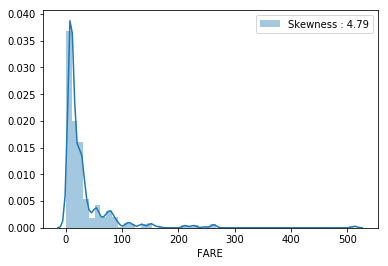

In [19]:
# Explore Fare distribution 
g = sns.distplot(titanic_train.collect().FARE, label="Skewness : %.2f"%(titanic_train.collect().FARE.skew()))
g = g.legend(loc="best")

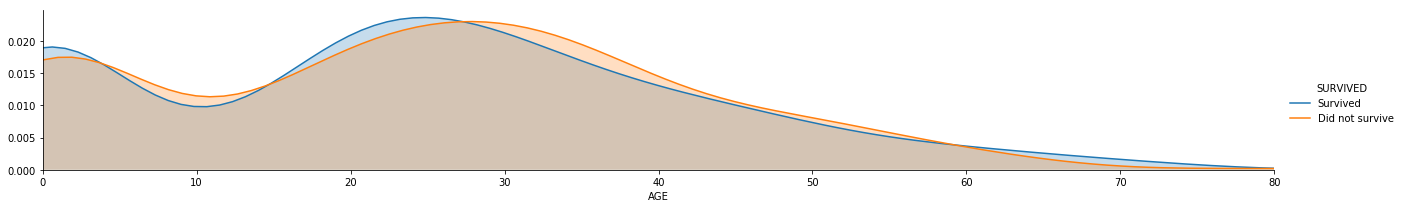

In [20]:
#check distribution of AGE by plotting
a = sns.FacetGrid( titanic_train.collect(), hue = 'SURVIVED', aspect=6 )
a.map(sns.kdeplot, 'AGE', shade= True )
a.set(xlim=(0 , titanic_train.collect()['AGE'].max()))
a.add_legend()

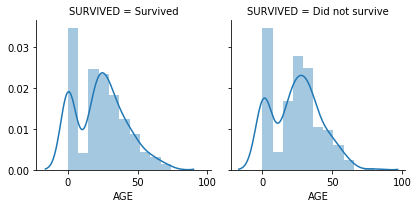

In [21]:
# Explore Age vs Survived
g = sns.FacetGrid(titanic_train.collect(), col='SURVIVED')
g = g.map(sns.distplot, "AGE")

## Modeling

In [22]:
# Create the RandomForestClassifier instance and specify the parameters
rfc = trees.RandomForestClassifier(conn_context=conn, n_estimators=3,
                              max_features=3, random_state=2,
                              split_threshold=0.00001,
                              calculate_oob=True,
                              min_samples_leaf=1, thread_ratio=1.0)

# Store the necessary features in a list and invoke the fit method to train the algorithm
rfc.fit(titanic_train, key='PID', label='SURVIVED')

In [23]:
# Print the accuracy score of this trained model using the score method
print("Trained model accuracy score: {:.2f}". format(rfc.score(data=titanic_train, key='PID')*100) + str('%'))

Trained model accuracy score: 92.03%


## Interpretation
Accuracy score looks good but I would not trust it because we didn't do EDA with data cleaning and feature engineering. Because this use case is mainly for proving the technical feasibility I go on with the prediction<br><br>

In [24]:
# do prediction and check data
y_pred = rfc.predict(titanic_test, key="PID", verbose=False)
y_pred.head(10).collect()

,PID,SCORE,CONFIDENCE
0,892,Survived,1.000000
1,893,Survived,0.666667
2,894,Survived,0.666667
3,895,Did not survive,0.666667
4,896,Did not survive,0.666667
5,897,Survived,1.000000
6,898,Did not survive,0.666667
7,899,Survived,1.000000
8,900,Did not survive,1.000000
9,901,Survived,1.000000


# Result
* Implementation of RandomForest classification model in SAP HANA successful
* All data intensive operations can be done in the HANA database

## Export model to HANA
Attention: this feature is still undocumented for PAL and might change
See my question in SAP Community: https://answers.sap.com/questions/12684767/export-python-ml-model-to-hana-for-productive-use.html

In [25]:
model = rfc.model_.select('ROW_INDEX', 'MODEL_CONTENT') 
model.save(<schema>, "TITANIC_RFC") #overwriting not possible yet. Workaround: Create new table

## Import model from HANA

In [26]:
df_model_saved = dataframe.DataFrame(conn, 'select * from <schema>.TITANIC_RFC') 
tree_reg_saved = trees.RandomForestClassifier(conn) 
tree_reg_saved.model_ = df_model_saved.select('ROW_INDEX', 'MODEL_CONTENT')

In [27]:
tree_reg_saved.model_.collect()     # this is how the model is saved in the HANA database

,ROW_INDEX,MODEL_CONTENT
0,0,"<PMML version=""4.0"" xmlns=""http://www.dmg.org/..."
1,1,"<PMML version=""4.0"" xmlns=""http://www.dmg.org/..."
2,2,"=""lt"" v=""17.5"" />\n<sd v=""Survived"" n=""68"" />\..."
3,3,"e>\n<Node id=""66"" sc=""Did not survive"" n=""7"" >..."
4,4,"de id=""102"" sc=""Did not survive"" n=""3"" >\n<sp ..."
5,5,"lt"" v=""49"" />\n<sd v=""Survived"" n=""0"" />\n<sd ..."
6,6,"0"" />\n</Node>\n</Node>\n<Node id=""172"" sc=""Di..."
7,7,"/>\n<sd v=""Did not survive"" n=""10"" />\n</Node>..."
8,8,"<PMML version=""4.0"" xmlns=""http://www.dmg.org/..."
9,9,"/>\n<sd v=""Did not survive"" n=""3"" />\n</Node>..."


## Automation
To have PAL or APL models retrained and applied automatically SAP Data Intelligence (SAP DI = Data Hub + ML in the cloud) can be used. You can deploy the Python syntax there as Python operator in a graph. You could use that SAP Data Intelligence also to expose the trained model as REST API web service.